In [1]:
from collections import defaultdict
import json
import numpy as np
import pandas as pd
import requests

In [2]:
TOTAL_FUNDING = 8_000_000
MAX_CAP = 1_000_000
MIN_CAP = 10_000

# since the synthetic data has a normal distribution, we need to more aggressive cap for testing
MAX_CAP = 100_000
MIN_CAP = 60_000

In [3]:
# placeholder for making API calls

KEY = 'your_key'
CURSOR = 0
f"""
curl -X 'GET' \
  'https://vote.optimism.io/api/v1/retrofunding/rounds/5/projects?limit=100&offset={CURSOR}&category=all' \
  -H 'accept: application/json' \
  -H 'Authorization: Bearer {KEY}'
"""

print("Fetch the data...")

Fetch the data...


In [4]:
synthetic_data = json.load(open("rf5_synthetic_ballots.json"))
synthetic_data[-2]

{'voter_id': '0x119f1de87734c3a34aa2aa3770f0dea2f87eafd6',
 'category_assignment': 'eth_core',
 'category_allocations': {'eth_core': 8.073236667485869,
  'op_tooling': 12.804128778569673,
  'op_rnd': 79.12263455394447},
 'project_allocations': {'0xf7e1ec3f5bbedbf4690cd35fc943e67cafad78aa6c08b7b70d2d3fd2e9e38e92': 5.256508779283684,
  '0xeb16b19c93c3e61b5523edc2c7b420a8f5517fcc142682bd2ee20fc19bd66555': 4.524125564715196,
  '0x7216d74097de26f7eb4ff881d7e71bf347f7dad15847dce07b8430d5a79b6e42': 5.241372083275114,
  '0xe94989a17727f4a4eed85bfb646382ad1a0fd9b4daa14408150f45d36ea452ff': 2.4731032555540025,
  '0x98e08fab7eee81c02a87985098f9242e80a2722b399e9b7f8452b4ef6bb53d34': 4.507242326859484,
  '0xf87d2af235702c9a9473cd4f92e0f67e8031923c2dcc588454abb68deacb90da': 4.812304969493735,
  '0x21960f3fa8a606d941675a0944d5595508076cb6e30eeafa7f0f01535781e918': 0.9408038749941781,
  '0x2c2c03c877b2033f6e83dc2347a0c5967e8d6fa1d366f1ad1d9131fc37472d01': 2.9563131665968045,
  '0xa03f8f248f6f9a040df59

In [5]:
NUM_VOTERS = len(synthetic_data)
CATEGORIES = list(synthetic_data[-1]['category_allocations'].keys())
NUM_CATEGORIES = len(CATEGORIES)
PROJECTS = list(set([p for vote in synthetic_data for p in vote['project_allocations'].keys()]))
NUM_PROJECTS = len(PROJECTS)
print(CATEGORIES)

['eth_core', 'op_tooling', 'op_rnd']


In [6]:
# Step 0. Parse all the ballots (and remove null votes)
category_scores = defaultdict(list)
project_scores = defaultdict(lambda: defaultdict(list))
for ballot in synthetic_data:
    assigned_category = ballot['category_assignment']
    for category, category_percentage in ballot['category_allocations'].items():
        category_scores[category].append(category_percentage)

    for project, project_percentage in ballot['project_allocations'].items():
        if project_percentage:
            project_scores[assigned_category][project].append(project_percentage)

# Step 1. Calculate medians for categories and normalize to weights across categories
category_medians = {k: np.median(v)/100 for k, v in category_scores.items()}    
category_total = sum(category_medians.values())
category_weights = {k: v/category_total for k, v in category_medians.items()}

# Step 2. Calculate medians for projects and normalize to weights within a category
project_weights = defaultdict(lambda: defaultdict(list))
for category, project_dict in project_scores.items():
    for project, scores in project_dict.items():
        project_weights[category][project] = np.median(scores) / 100
    category_subtotal = sum(project_weights[category].values())
    for k, v in project_weights[category].items():
        project_weights[category][k] = v/category_subtotal 

# Step 3. Create an initial series of project funding allocations
initial_project_allocations = pd.Series()
for category, projects in project_weights.items():
    for project, score in projects.items():
        initial_project_allocations.loc[project] = score * category_weights[category] * TOTAL_FUNDING

# Check the results makes sense
for c in CATEGORIES:
    print("Category:", c)
    print("Allocation:", category_weights[c])
    print("Projects:", len(project_weights[c]))
    print("Total Project Allocation:", sum(project_weights[c].values()))
    print()

print("Total Funding:", initial_project_allocations.sum())

Category: eth_core
Allocation: 0.30737783743592223
Projects: 34
Total Project Allocation: 1.0000000000000002

Category: op_tooling
Allocation: 0.33175528520176595
Projects: 33
Total Project Allocation: 1.0000000000000002

Category: op_rnd
Allocation: 0.36086687736231177
Projects: 33
Total Project Allocation: 1.0

Total Funding: 8000000.0


Final Results:
 - Projects: 100
 - Voters: 100
 - Funding Available: 8000000
 - Funding Awarded: 8000000


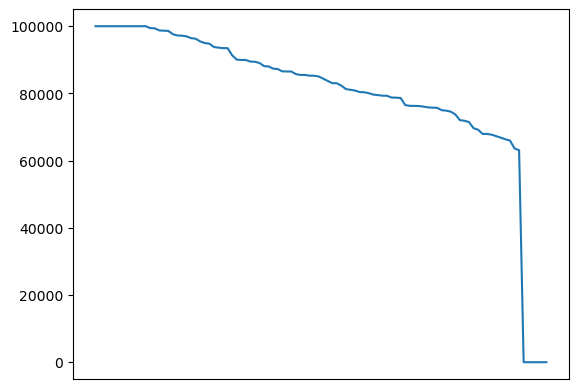

In [7]:
def allocate_funding(project_scores, funding_balance=TOTAL_FUNDING):
    """
    Helper for allocating and redistributing funding balances
    """
    score_balance = project_scores.sum()
    allocations = pd.Series()
    
    for project, score in project_scores.sort_values(ascending=False).items():
        uncapped_funding_alloc = score / score_balance * funding_balance
        capped_funding_alloc = min(uncapped_funding_alloc, MAX_CAP)
        allocations.loc[project] = capped_funding_alloc
        funding_balance -= capped_funding_alloc
        score_balance -= score

    return allocations


# Step 4. Implement max cap and redistribute excess
capped_allocations = allocate_funding(initial_project_allocations)

# Step 5. Set the funding for projects below the minimum cap to 0
capped_allocations.loc[capped_allocations < MIN_CAP] = 0

# Step 6. Allocate the remaining funding to projects below the maximum cap
max_cap_funding = capped_allocations[capped_allocations == MAX_CAP].sum()
remaining_funding = TOTAL_FUNDING - max_cap_funding
remaining_projects = capped_allocations[capped_allocations < MAX_CAP]
capped_allocations.update(allocate_funding(remaining_projects, funding_balance=remaining_funding))

capped_allocations.to_csv('rf5_synthetic_ballots_results.csv', header=['allocation'])

# Check the results
capped_allocations.plot(xticks=[])
print("Final Results:")
print(" - Projects:", NUM_PROJECTS)
print(" - Voters:", NUM_VOTERS)
print(" - Funding Available:", TOTAL_FUNDING)
print(" - Funding Awarded:", round(capped_allocations.sum()))

<Axes: >

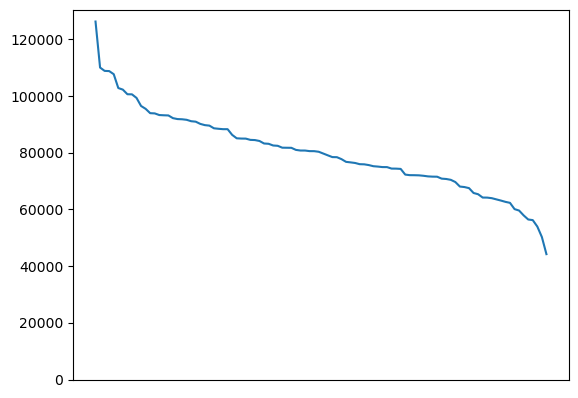

In [8]:
initial_project_allocations.sort_values(ascending=False).plot(xticks=[], ylim=(0))

<Axes: >

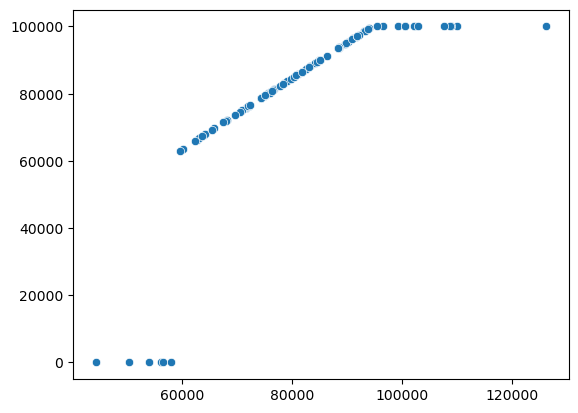

In [9]:
import seaborn as sns
sns.scatterplot(x=initial_project_allocations, y=capped_allocations)